# Deep Q-Learning

# 1. y 3. Deep Q-Network (I)

In [1]:
import torch
import torch.nn as nn

import copy

import numpy as np

from replay_buffer import ReplayBuffer

from torch.optim import AdamW

import torch.nn.functional as F

c:\Users\jose.luis.cadiz\Anaconda3\envs\Ti_RL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DeepQNetwork(nn.Module):
    
    def __init__(self, dim_states, dim_actions):
        super(DeepQNetwork, self).__init__()
        # MLP, fully connected layers, ReLU activations, linear ouput activation
        # dim_states -> 64 -> 64 -> dim_actions

        # Inicialización de pesos con distribución uniforme
        def init_weights(m):
            if isinstance(m, nn.Linear):

                #nn.init.normal_(m.weight, mean=0.0, std=1)
                #nn.init.normal_(m.weight, mean=0.0, std=1)
                nn.init.uniform_(m.weight, a=0.0, b=1.0)
                nn.init.uniform_(m.bias, a=0.0, b=1.0)
                
        self.layers = nn.Sequential(
            nn.Linear(dim_states, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, dim_actions)
        )

        self.layers.apply(init_weights)

    def forward(self, input):

        # tensor format
        if isinstance(input, torch.Tensor):
            input=input
            
        else:
            input = torch.from_numpy(input).unsqueeze(dim=0).float()
            
        q_values = self.layers(input)

        return q_values

class DeepQNetworkAgent:

    def __init__(self, dim_states, dim_actions, lr, gamma, epsilon, nb_training_steps, replay_buffer_size, batch_size):
        
        self._learning_rate = lr
        self._gamma = gamma
        self._epsilon = epsilon

        self._epsilon_min = 0.0
        self._epsilon_decay = self._epsilon / (nb_training_steps / 2.)

        self._dim_states = dim_states
        self._dim_actions = dim_actions

        self.replay_buffer = ReplayBuffer(dim_states=self._dim_states,
                                          dim_actions=self._dim_actions,
                                          max_size=replay_buffer_size,
                                          sample_size=batch_size)

        # Complete
        self._deep_qnetwork = DeepQNetwork(self._dim_states, self._dim_actions)
        self._target_deepq_network = copy.deepcopy(self._deep_qnetwork).eval()

        # Adam optimizer
        self._optimizer = AdamW(self._deep_qnetwork.parameters(), lr=self._learning_rate)


    def store_transition(self, s_t, a_t, r_t, s_t1, done_t):
        self.replay_buffer.store_transition(s_t, a_t, r_t, s_t1, done_t)


    def replace_target_network(self):
        self._target_deepq_network.load_state_dict(self._deep_qnetwork.state_dict())
        

    def select_action(self, observation, greedy=False):
        
           
            if np.random.random() > self._epsilon or greedy:
                # Select action greedily

                # Action values
                qa = self._deep_qnetwork(observation)

                # Action con mayor q-value
                action=qa.argmax().item()
        
            else:
                # Exploración
                action=np.random.randint(2)

            if not greedy and self._epsilon >= self._epsilon_min:
                
                # Implement epsilon linear decay
                self._epsilon-=self._epsilon_decay 
                

            return action

    def update(self):
        s_t,a_t,r_t,s_t1,done=self.replay_buffer.sample_transitions()

        s_t=torch.from_numpy(s_t).unsqueeze(dim=0).float()
        s_t1=torch.from_numpy(s_t1).unsqueeze(dim=0).float()
        r_t = torch.tensor(r_t).view(-1, 1).float()
        done = torch.tensor(done).view(-1, 1)
        a_t=torch.tensor(a_t).view(-1, 1).type(torch.int64)

        # Predict Q-value de estado actual
        qsa_predict=self._deep_qnetwork(s_t)
        qsa_actions=torch.gather(input=qsa_predict[0], dim=1,index = a_t)
        
        # Calculo de Q-value target (Q-value estado siguiente)
        next_qsa_predict=self._target_deepq_network(s_t1)
        max_next_qsa_predict=torch.max(next_qsa_predict, dim=-1, keepdim=True)[0][0]

        target_qsa=r_t+~done*self._gamma*max_next_qsa_predict

        loss = F.mse_loss(qsa_actions, target_qsa)
        self._deep_qnetwork.zero_grad()
        loss.backward()
        self._optimizer.step()

In [3]:
import gym
env = gym.make('CartPole-v1')
eval_env = gym.make('CartPole-v1')

# Actions are discrete
dim_actions = np.array(env.action_space.n)

# States are continuous
dim_states = env.observation_space.shape[0]

print(dim_states)
print(dim_actions)

4
2


In [4]:
deep_qnetwork = DeepQNetwork(dim_states, dim_actions)
deep_qnetwork

DeepQNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [5]:
target_deepq_network = copy.deepcopy(deep_qnetwork).eval()
target_deepq_network

DeepQNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [6]:
observation=env.reset()
observation

array([0.00741166, 0.01114797, 0.04307327, 0.04042631], dtype=float32)

In [7]:
qsa=deep_qnetwork(observation)
qsa

tensor([[469.0515, 499.0370]], grad_fn=<AddmmBackward>)

In [8]:
observation = torch.from_numpy(observation).unsqueeze(dim=0).float()
observation

tensor([[0.0074, 0.0111, 0.0431, 0.0404]])

In [9]:
qsa=deep_qnetwork(observation)
qsa

tensor([[469.0515, 499.0370]], grad_fn=<AddmmBackward>)

# 2. Replay Buffer

In [10]:
import gym
import numpy as np

In [11]:
class ReplayBuffer:
    
    def __init__(self, dim_states, dim_actions, max_size, sample_size):

        assert sample_size < max_size, "Sample size cannot be greater than buffer size"
        
        self._buffer_idx     = 0
        self._exps_stored    = 0
        self._buffer_size    = max_size
        self._sample_size    = sample_size

        self._s_t_array      = np.zeros((max_size, dim_states))
        self._a_t_array      = np.zeros((max_size))
        self._r_t_array      = np.zeros((max_size,))
        self._s_t1_array     = np.zeros((max_size, dim_states))
        self._term_t_array   = np.zeros((max_size,), dtype=bool)


    def store_transition(self, s_t, a_t, r_t, s_t1, done_t):

        # Add transition to replay buffer according to self._buffer_idx
        self._s_t_array[self._buffer_idx]=s_t   
        self._a_t_array[self._buffer_idx]=a_t  
        self._r_t_array[self._buffer_idx]=r_t  
        self._s_t1_array[self._buffer_idx]=s_t1 
        self._term_t_array[self._buffer_idx]=done_t

        # Update replay buffer index
        # Aumento de indice y reinicio de indice si superamos capacidad
        self._buffer_idx = (self._buffer_idx + 1) % self._buffer_size
        self._exps_stored += 1

    
    def sample_transitions(self):
        assert self._exps_stored + 1 > self._sample_size, "Not enough samples have been stored to start sampling"
        
        sample_idxs = np.random.choice(self._buffer_size, size=self._sample_size,replace=False)
        
        return (self._s_t_array[sample_idxs],
                self._a_t_array[sample_idxs],
                self._r_t_array[sample_idxs],
                self._s_t1_array[sample_idxs],
                self._term_t_array[sample_idxs])
        

**Corroboración del correcto funcionamiento:**

In [12]:
# Ambiente: CartPole
env = gym.make('CartPole-v1')
eval_env = gym.make('CartPole-v1')

# Actions are discrete
dim_actions = np.array(env.action_space.n)

# States are continuous
dim_states = env.observation_space.shape[0]

print(dim_states)
print(dim_actions)

4
2


In [13]:
# Inicialización de memory Buffer
max_size=5
sample_size=3
memory=ReplayBuffer(dim_states, dim_actions, max_size, sample_size)

In [14]:
# Simulación de 6 transiciones
s_t=env.reset()

for i in range(6):
   
    a_t=np.random.randint(2)
    s_t1, r_t, done_t, _ = env.step(a_t)
    print(s_t1, r_t, done_t)

    # Guardar
    memory.store_transition(s_t, a_t, r_t, s_t1, done_t)

    s_t = s_t1

[ 0.00593574 -0.17127012 -0.02576173  0.2443883 ] 1.0 False
[ 0.00251034  0.02421015 -0.02087396 -0.0563079 ] 1.0 False
[ 0.00299455 -0.17060639 -0.02200012  0.22971673] 1.0 False
[-4.1758240e-04 -3.6540717e-01 -1.7405786e-02  5.1537967e-01] 1.0 False
[-0.00772573 -0.17004447 -0.00709819  0.217263  ] 1.0 False
[-0.01112662  0.02517823 -0.00275293 -0.07765053] 1.0 False


In [15]:
# Datos almacenados: Conjunto de estados almacenados
memory._s_t1_array

array([[-1.11266151e-02,  2.51782257e-02, -2.75293179e-03,
        -7.76505321e-02],
       [ 2.51034228e-03,  2.42101457e-02, -2.08739620e-02,
        -5.63078970e-02],
       [ 2.99454527e-03, -1.70606390e-01, -2.20001191e-02,
         2.29716733e-01],
       [-4.17582400e-04, -3.65407169e-01, -1.74057856e-02,
         5.15379667e-01],
       [-7.72572542e-03, -1.70044467e-01, -7.09819188e-03,
         2.17262998e-01]])

**Se observa como el sexto elemento de la transición de estados, coincide con el primer elemento del conjunto de estados almacenados. Esto debido a que la data se va sobrescribiendo en la medida de que hay nuevos registros.**

In [16]:
# Se guardan a los 5 elementos, los cuales son el max_size del buffer
memory._s_t1_array.shape

(5, 4)

In [17]:
# Sample
memory.sample_transitions()

(array([[ 2.99454527e-03, -1.70606390e-01, -2.20001191e-02,
          2.29716733e-01],
        [-4.17582400e-04, -3.65407169e-01, -1.74057856e-02,
          5.15379667e-01],
        [-7.72572542e-03, -1.70044467e-01, -7.09819188e-03,
          2.17262998e-01]]),
 array([0., 1., 1.]),
 array([1., 1., 1.]),
 array([[-4.17582400e-04, -3.65407169e-01, -1.74057856e-02,
          5.15379667e-01],
        [-7.72572542e-03, -1.70044467e-01, -7.09819188e-03,
          2.17262998e-01],
        [-1.11266151e-02,  2.51782257e-02, -2.75293179e-03,
         -7.76505321e-02]]),
 array([False, False, False]))

In [18]:
# Se observa el muestreo de 3 elementos para el conjunto de estados
len(memory.sample_transitions()[0])

3

-----

# Prueba de la dinámica RN y Replay Buffer

In [19]:
s_t,a_t,r_t,s_t1,done=memory.sample_transitions()

In [20]:
s_t=torch.from_numpy(s_t).unsqueeze(dim=0).float()
s_t

tensor([[[ 0.0059, -0.1713, -0.0258,  0.2444],
         [ 0.0025,  0.0242, -0.0209, -0.0563],
         [ 0.0030, -0.1706, -0.0220,  0.2297]]])

In [21]:
s_t1=torch.from_numpy(s_t1).unsqueeze(dim=0).float()
s_t1

tensor([[[ 2.5103e-03,  2.4210e-02, -2.0874e-02, -5.6308e-02],
         [ 2.9945e-03, -1.7061e-01, -2.2000e-02,  2.2972e-01],
         [-4.1758e-04, -3.6541e-01, -1.7406e-02,  5.1538e-01]]])

In [22]:
r_t = torch.tensor(r_t).view(-1, 1).float()
r_t

tensor([[1.],
        [1.],
        [1.]])

In [23]:
done = torch.tensor(done).view(-1, 1)
done

tensor([[False],
        [False],
        [False]])

In [24]:
a_t=torch.tensor(a_t).view(-1, 1).type(torch.int64)
a_t

tensor([[1],
        [0],
        [0]])

In [25]:
# Predict Q-value de estado actual
qsa_predict=deep_qnetwork(s_t)
print(qsa_predict)
qsa_actions=torch.gather(input=qsa_predict[0], dim=1,index = a_t)
print(qsa_actions)

tensor([[[436.3583, 464.7362],
         [402.0907, 428.2186],
         [431.0654, 459.1133]]], grad_fn=<AddBackward0>)
tensor([[464.7362],
        [402.0907],
        [431.0654]], grad_fn=<GatherBackward>)


In [26]:
qsa_actions.shape

torch.Size([3, 1])

In [27]:
# Calculo de Q-value target (Q-value estado siguiente)
next_qsa_predict=target_deepq_network(s_t1)
next_qsa_predict

tensor([[[402.0907, 428.2186],
         [431.0654, 459.1133],
         [465.4113, 495.7042]]], grad_fn=<AddBackward0>)

In [28]:
max_next_qsa_predict=torch.max(next_qsa_predict, dim=-1, keepdim=True)[0][0]
max_next_qsa_predict

tensor([[428.2186],
        [459.1133],
        [495.7042]], grad_fn=<SelectBackward>)

In [29]:
gamma=0.99

In [30]:
target_qsa=r_t+~done*gamma*max_next_qsa_predict
target_qsa

tensor([[424.9364],
        [455.5222],
        [491.7472]], grad_fn=<AddBackward0>)

In [31]:
target_qsa.shape

torch.Size([3, 1])

In [32]:
optimizer = AdamW(deep_qnetwork.parameters(), lr=0.001)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [33]:
loss = F.mse_loss(qsa_actions, target_qsa)
deep_qnetwork.zero_grad()
loss.backward()
optimizer.step()

---------

# Read métricas 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
exp_11_1=pd.read_csv("exp_11_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_11_2=pd.read_csv("exp_11_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_11_3=pd.read_csv("exp_11_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_11_4=pd.read_csv("exp_11_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_11_5=pd.read_csv("exp_11_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

exp_12_1=pd.read_csv("exp_12_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_12_2=pd.read_csv("exp_12_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_12_3=pd.read_csv("exp_12_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_12_4=pd.read_csv("exp_12_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_12_5=pd.read_csv("exp_12_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

exp_13_1=pd.read_csv("exp_13_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_13_2=pd.read_csv("exp_13_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_13_3=pd.read_csv("exp_13_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_13_4=pd.read_csv("exp_13_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_13_5=pd.read_csv("exp_13_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})


In [3]:
exp_21_1=pd.read_csv("exp_21_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_21_2=pd.read_csv("exp_21_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_21_3=pd.read_csv("exp_21_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_21_4=pd.read_csv("exp_21_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_21_5=pd.read_csv("exp_21_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

exp_22_1=pd.read_csv("exp_22_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_22_2=pd.read_csv("exp_22_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_22_3=pd.read_csv("exp_22_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_22_4=pd.read_csv("exp_22_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_22_5=pd.read_csv("exp_22_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

exp_23_1=pd.read_csv("exp_23_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_23_2=pd.read_csv("exp_23_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_23_3=pd.read_csv("exp_23_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_23_4=pd.read_csv("exp_23_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_23_5=pd.read_csv("exp_23_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

In [4]:
exp_31_1=pd.read_csv("exp_31_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_31_2=pd.read_csv("exp_31_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_31_3=pd.read_csv("exp_31_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_31_4=pd.read_csv("exp_31_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_31_5=pd.read_csv("exp_31_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

exp_32_1=pd.read_csv("exp_32_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_32_2=pd.read_csv("exp_32_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_32_3=pd.read_csv("exp_32_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_32_4=pd.read_csv("exp_32_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_32_5=pd.read_csv("exp_32_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

exp_33_1=pd.read_csv("exp_33_1.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1",	"success_rate":"success_rat1"})
exp_33_2=pd.read_csv("exp_33_2.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2",	"success_rate":"success_rat2"})
exp_33_3=pd.read_csv("exp_33_3.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3",	"success_rate":"success_rat3"})
exp_33_4=pd.read_csv("exp_33_4.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward4","std_reward":"std_reward4",	"success_rate":"success_rat4"})
exp_33_5=pd.read_csv("exp_33_5.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward5","std_reward":"std_reward5",	"success_rate":"success_rat5"})

# Exp_11

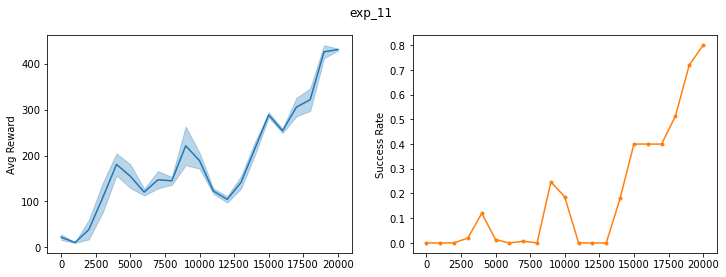

In [5]:
# join de experimentos
exp_11=exp_11_1
for i in [exp_11_2,exp_11_3,exp_11_4,exp_11_5]:
    exp_11=exp_11.join(i)

# Promedio de experimentos
exp_11_mean=pd.DataFrame()
exp_11_mean["avg_reward"]=exp_11[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_11_mean["std_reward"]=exp_11[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_11_mean["success_rat"]=exp_11[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_11_mean.reset_index(inplace=True)
tr_steps_vec=exp_11_mean["steps"]
avg_reward_vec=exp_11_mean["avg_reward"]
std_reward_vec= exp_11_mean["std_reward"]
success_rate_vec=exp_11_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_11")
plt.show()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.errorbar(tr_steps_vec, avg_reward_vec, yerr=std_reward_vec, marker='.',color='C0')

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')

plt.suptitle("exp_11")
plt.show()

# Exp_12

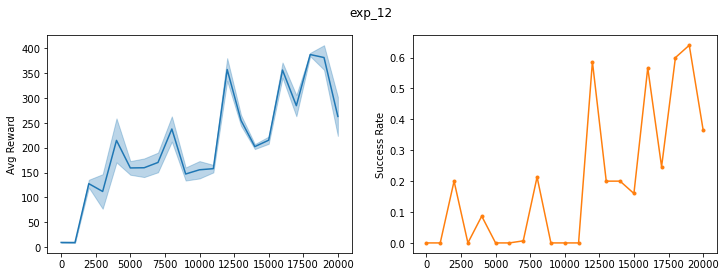

In [7]:
# join de experimentos
exp_12=exp_12_1
for i in [exp_12_2,exp_12_3,exp_12_4,exp_12_5]:
    exp_12=exp_12.join(i)

# Promedio de experimentos
exp_12_mean=pd.DataFrame()
exp_12_mean["avg_reward"]=exp_12[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_12_mean["std_reward"]=exp_12[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_12_mean["success_rat"]=exp_12[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_12_mean.reset_index(inplace=True)
tr_steps_vec=exp_12_mean["steps"]
avg_reward_vec=exp_12_mean["avg_reward"]
std_reward_vec= exp_12_mean["std_reward"]
success_rate_vec=exp_12_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_12")
plt.show()

# Exp_13

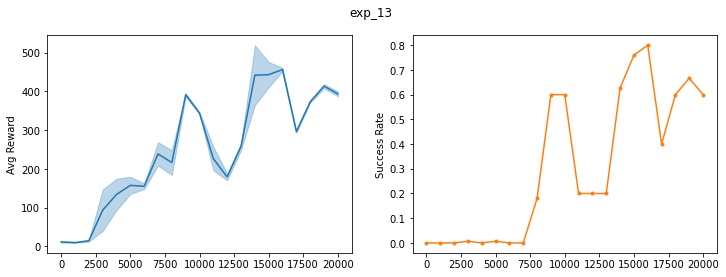

In [8]:
# join de experimentos
exp_13=exp_13_1
for i in [exp_13_2,exp_13_3,exp_13_4,exp_13_5]:
    exp_13=exp_13.join(i)

# Promedio de experimentos
exp_13_mean=pd.DataFrame()
exp_13_mean["avg_reward"]=exp_13[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_13_mean["std_reward"]=exp_13[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_13_mean["success_rat"]=exp_13[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_13_mean.reset_index(inplace=True)
tr_steps_vec=exp_13_mean["steps"]
avg_reward_vec=exp_13_mean["avg_reward"]
std_reward_vec= exp_13_mean["std_reward"]
success_rate_vec=exp_13_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_13")
plt.show()

# Exp_21

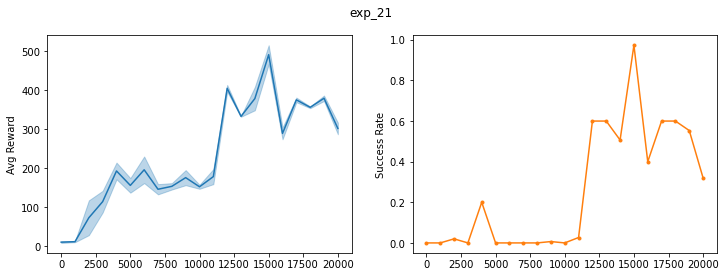

In [9]:
# join de experimentos
exp_21=exp_21_1
for i in [exp_21_2,exp_21_3,exp_21_4,exp_21_5]:
    exp_21=exp_21.join(i)

# Promedio de experimentos
exp_21_mean=pd.DataFrame()
exp_21_mean["avg_reward"]=exp_21[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_21_mean["std_reward"]=exp_21[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_21_mean["success_rat"]=exp_21[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_21_mean.reset_index(inplace=True)
tr_steps_vec=exp_21_mean["steps"]
avg_reward_vec=exp_21_mean["avg_reward"]
std_reward_vec= exp_21_mean["std_reward"]
success_rate_vec=exp_21_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_21")
plt.show()

# Exp_22

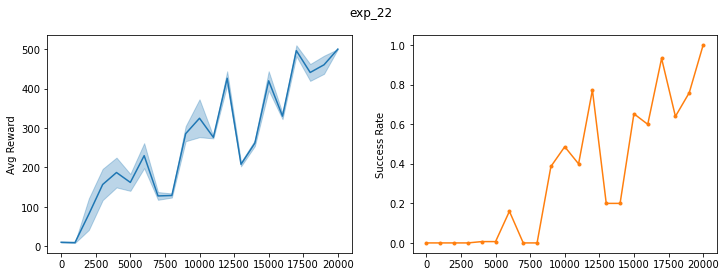

In [10]:
# join de experimentos
exp_22=exp_22_1
for i in [exp_22_2,exp_22_3,exp_22_4,exp_22_5]:
    exp_22=exp_22.join(i)

# Promedio de experimentos
exp_22_mean=pd.DataFrame()
exp_22_mean["avg_reward"]=exp_22[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_22_mean["std_reward"]=exp_22[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_22_mean["success_rat"]=exp_22[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_22_mean.reset_index(inplace=True)
tr_steps_vec=exp_22_mean["steps"]
avg_reward_vec=exp_22_mean["avg_reward"]
std_reward_vec= exp_22_mean["std_reward"]
success_rate_vec=exp_22_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_22")
plt.show()

# Exp_23

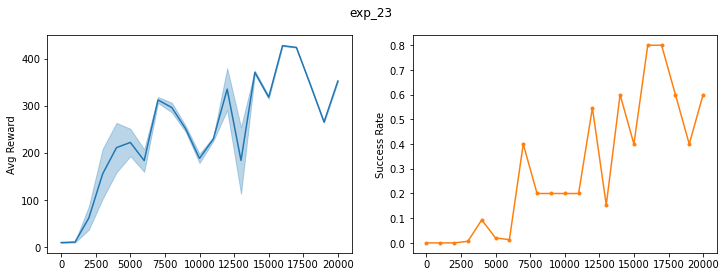

In [11]:
# join de experimentos
exp_23=exp_23_1
for i in [exp_23_2,exp_23_3,exp_23_4,exp_23_5]:
    exp_23=exp_23.join(i)

# Promedio de experimentos
exp_23_mean=pd.DataFrame()
exp_23_mean["avg_reward"]=exp_23[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_23_mean["std_reward"]=exp_23[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_23_mean["success_rat"]=exp_23[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_23_mean.reset_index(inplace=True)
tr_steps_vec=exp_23_mean["steps"]
avg_reward_vec=exp_23_mean["avg_reward"]
std_reward_vec= exp_23_mean["std_reward"]
success_rate_vec=exp_23_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_23")
plt.show()

# Exp_31

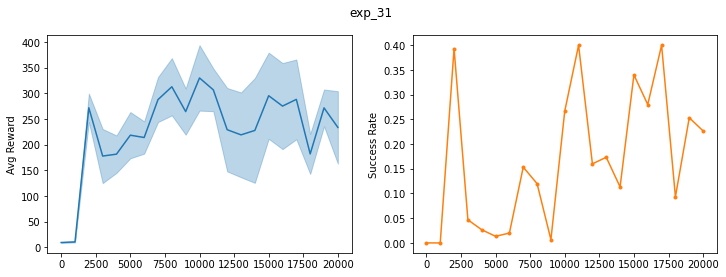

In [12]:
# join de experimentos
exp_31=exp_31_1
for i in [exp_31_2,exp_31_3,exp_31_4,exp_31_5]:
    exp_31=exp_31.join(i)

# Promedio de experimentos
exp_31_mean=pd.DataFrame()
exp_31_mean["avg_reward"]=exp_31[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_31_mean["std_reward"]=exp_31[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_31_mean["success_rat"]=exp_31[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_31_mean.reset_index(inplace=True)
tr_steps_vec=exp_31_mean["steps"]
avg_reward_vec=exp_31_mean["avg_reward"]
std_reward_vec= exp_31_mean["std_reward"]
success_rate_vec=exp_31_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_31")
plt.show()

# Exp_32

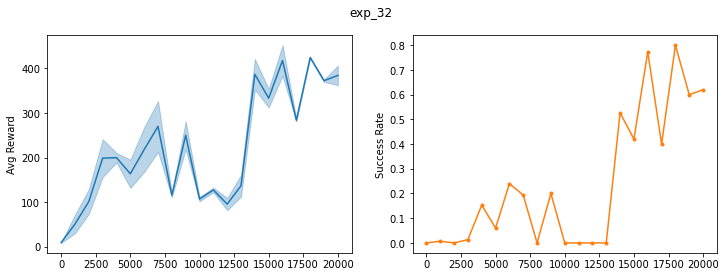

In [13]:
# join de experimentos
exp_32=exp_32_1
for i in [exp_32_2,exp_32_3,exp_32_4,exp_32_5]:
    exp_32=exp_32.join(i)

# Promedio de experimentos
exp_32_mean=pd.DataFrame()
exp_32_mean["avg_reward"]=exp_32[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_32_mean["std_reward"]=exp_32[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_32_mean["success_rat"]=exp_32[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_32_mean.reset_index(inplace=True)
tr_steps_vec=exp_32_mean["steps"]
avg_reward_vec=exp_32_mean["avg_reward"]
std_reward_vec= exp_32_mean["std_reward"]
success_rate_vec=exp_32_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_32")
plt.show()

# Exp_33

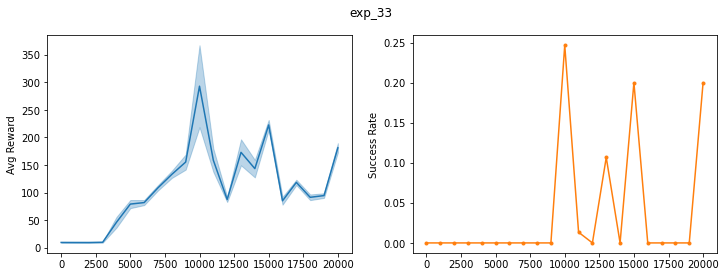

In [14]:
# join de experimentos
exp_33=exp_33_1
for i in [exp_33_2,exp_33_3,exp_33_4,exp_33_5]:
    exp_33=exp_33.join(i)

# Promedio de experimentos
exp_33_mean=pd.DataFrame()
exp_33_mean["avg_reward"]=exp_33[["avg_reward1","avg_reward2","avg_reward3","avg_reward4","avg_reward5"]].mean(axis=1)
exp_33_mean["std_reward"]=exp_33[["std_reward1","std_reward2","std_reward3","std_reward4","std_reward5"]].mean(axis=1)
exp_33_mean["success_rat"]=exp_33[["success_rat1","success_rat2","success_rat3","success_rat4","success_rat5"]].mean(axis=1)
exp_33_mean.reset_index(inplace=True)
tr_steps_vec=exp_33_mean["steps"]
avg_reward_vec=exp_33_mean["avg_reward"]
std_reward_vec= exp_33_mean["std_reward"]
success_rate_vec=exp_33_mean["success_rat"]

# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)

ax1.set_ylabel('Avg Reward')
ax2.plot(tr_steps_vec, success_rate_vec, marker='.',color='C1')
ax2.set_ylabel('Success Rate')
plt.suptitle("exp_33")
plt.show()